In [2]:
from __future__ import annotations

import logging
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


In [3]:
subjects = {
    "Биология": "biology",
    "Физика": "physics",
    "Математика": "math",
    "Информатика": "informatics",
    "Религиоведение": "religion",
    "Английский": "english",
    "Программирование": "programming",
    "История": "history",
    "Литература": "literature",
    "География": "geography",
    "Введение в геометрию": "intro-geometry",
    "Музыка": "music",
    "Физическая культура": "physical-culture",
    "Русский язык": "russian",
    "Обществознание": "sociology",
    "Алгебра": "algebra",
    "Введение в химию": "intro-chemistry",
    "Вероятность и статистика": "statistics",
    "Геометрия": "geometry",
    "Немецкий язык": "german",
}

trimesters = {
    "III триместр": "3",
    "II триместр": "2",
    "I триместр": "1",
}

In [4]:
def get_new_name(name: str) -> dict[str, str]:
    """Rename a table name to be more readable.

    Args:
        name (str): The name of the table.

    Returns:
        dict[str, str]: A dictionary containing the new name for each column.s

    """
    _, year, grade, subject, trimester = name.split("_")
    return {
        "year": year,
        "grade": grade,
        "subject": subjects[subject],
        "trimester": trimesters.get(trimester),
    }


# Rename tables
dir_name = pathlib.Path("data")

for file in dir_name.iterdir():
    suffix = file.suffix
    name = file.stem

    new_name_dict = get_new_name(name)
    new_name_dict["suffix"] = suffix

    new_name = "{year}_{grade}_{subject}_{trimester}{suffix}".format(
        **new_name_dict,
    )

    new_file = file.with_name(new_name)
    file.rename(new_file)

    logger.info("Renamed %s to %s", file, new_file)

In [5]:
def process_dataframe(df: pd.DataFrame, table_name: str) -> pd.DataFrame:
    """Process a dataframe and returns a processed dataframe.

    Args:
        df (pd.DataFrame): The dataframe to be processed.
        table_name (str): The name of the table.

    Returns:
        pd.DataFrame: The processed dataframe.

    """
    student_ids: list[str] = []
    marks: list[int] = []

    marks_data: list[str] = []
    marks_weight: list[int] = []

    student_ids_column = df.iloc[3:, 0]

    df.iloc[3:, 0].dropna()

    for col in df.columns:
        mark_data = df[col][1]
        mark_weight = df[col][2]

        for i, val in enumerate(df[col][3:]):
            if type(val) in {int, float} and pd.notna(val):
                student_ids.append(student_ids_column[i + 3])
                marks.append(val)
                marks_data.append(mark_data)
                marks_weight.append(mark_weight)

    year, grade, subject, trimester = table_name.split("_")
    grade = grade.split("-")[0]

    result_df = pd.DataFrame(data={"student_id": student_ids, "mark": marks})
    result_df["grade"] = grade
    result_df["subject"] = subject
    result_df["trimester"] = trimester
    result_df["year"] = year
    result_df["marks_data"] = marks_data
    result_df["marks_weight"] = marks_weight

    return result_df.dropna(subset="student_id").reset_index(drop=True)

In [6]:
main_df = pd.DataFrame(
    columns=[
        "student_id",
        "mark",
        "grade",
        "subject",
        "trimester",
        "year",
        "marks_data",
        "marks_weight",
    ],
)

# Get all files in the directory and process them to a dataframe
for file in dir_name.iterdir():
    suffix = file.suffix
    name = file.stem

    dataframe = pd.read_excel(file)
    main_df = pd.concat(
        [main_df, process_dataframe(dataframe, name)],
        ignore_index=True,
    )

In [7]:
exclude_values = [
    "I", "II", "III", "Годовая", "Внутр. экз.",
]
main_df = main_df[~main_df["marks_data"].isin(exclude_values)]

In [8]:
import re

months = [
    "янв",
    "фев",
    "мар",
    "апр",
    "мая",
    "июн",
    "июл",
    "авг",
    "сен",
    "окт",
    "ноя",
    "дек",
]
months_dict = {month: i + 1 for i, month in enumerate(months)}


def get_date(str_date: str) -> tuple[int, int] | None:
    """Convert string date to tuple (int, int).

    Args:
        str_date (str): string date in format "ddmmm"

    Returns:
        tuple[int, int] | None: tuple (int, int) or None if string is not valid

    """
    re_match_number = re.match(r"\d+", str_date)
    if re_match_number is None:
        return None

    letter_match = re.search(r"[а-яА-Я]+", str_date)
    if letter_match is None:
        return None

    int_date_number = int(re_match_number.group())
    month = months_dict[letter_match.group()]
    return int_date_number, month


get_date("12дек")

(12, 12)

In [9]:
import datetime


def get_datetime_date(datetime_string: int, year: str) -> datetime.date | None:
    """Get the date from a datetime string and year.

    Args:
        datetime_string (int): The datetime string.
        year (str): The year.

    Returns:
        datetime.date | None: The date.

    """
    target_year: int
    begin_year, last_year = year.split("-")
    date_number, month = get_date(datetime_string)

    jan_int, dec_int, sep_int = 1, 12, 9
    if (month >= sep_int and month <= dec_int):
        target_year = int(begin_year)
    elif (month >= jan_int and month < sep_int):
        target_year = int(last_year)
    else:
        return None

    return datetime.date(target_year, month, date_number)


get_datetime_date(datetime_string="13дек", year="2022-2023")

datetime.date(2022, 12, 13)

In [10]:
main_df["mark_date"] = main_df.apply(
    lambda row: get_datetime_date(
        datetime_string=row["marks_data"],
        year=row["year"],
    ),
    axis=1,
)
main_df = main_df.drop(columns=["marks_data", "year"])

In [11]:
main_df["student_id"] = main_df["student_id"].astype(str)
main_df["mark"] = main_df["mark"].astype(int)
main_df["grade"] = main_df["grade"].astype(int)
main_df["subject"] = main_df["subject"].astype(str)
main_df["trimester"] = main_df["trimester"].astype(int)
main_df["marks_weight"] = main_df["marks_weight"].astype(str)
main_df["mark_date"] = pd.to_datetime(main_df["mark_date"])

main_df = main_df.reset_index()
main_df = main_df.drop(columns=["index"])
main_df.head()

,student_id,mark,grade,subject,trimester,marks_weight,mark_date
0,Student_4430,60,7,physical-culture,1,ФРМ,2024-09-17
1,Student_3517,100,7,physical-culture,1,ФРМ,2024-09-17
2,Student_1093,100,7,physical-culture,1,ФРМ,2024-09-20
3,Student_2940,100,7,physical-culture,1,ФРМ,2024-09-20
4,Student_6300,100,7,physical-culture,1,ФРМ,2024-09-20


In [12]:
main_df = main_df[~main_df["marks_weight"].isin({"K1", "K2", "K3", "nan"})]

In [13]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10537 entries, 0 to 10587
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   student_id    10537 non-null  object        
 1   mark          10537 non-null  int64         
 2   grade         10537 non-null  int64         
 3   subject       10537 non-null  object        
 4   trimester     10537 non-null  int64         
 5   marks_weight  10537 non-null  object        
 6   mark_date     10537 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 658.6+ KB


In [14]:
custom_dark_bw_palette = [
    "#D0D0D0",
    "#A0A0A0",
    "#808080",
    "#606060",
    "#404040",
    "#303030",
    "#202020",
]

/tmp/ipykernel_107290/1663144285.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)
/tmp/ipykernel_107290/1663144285.py:59: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)
/tmp/ipykernel_107290/1663144285.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_107290/1663144285.py:73: UserWarning: 
The palette list has fewer values (7) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


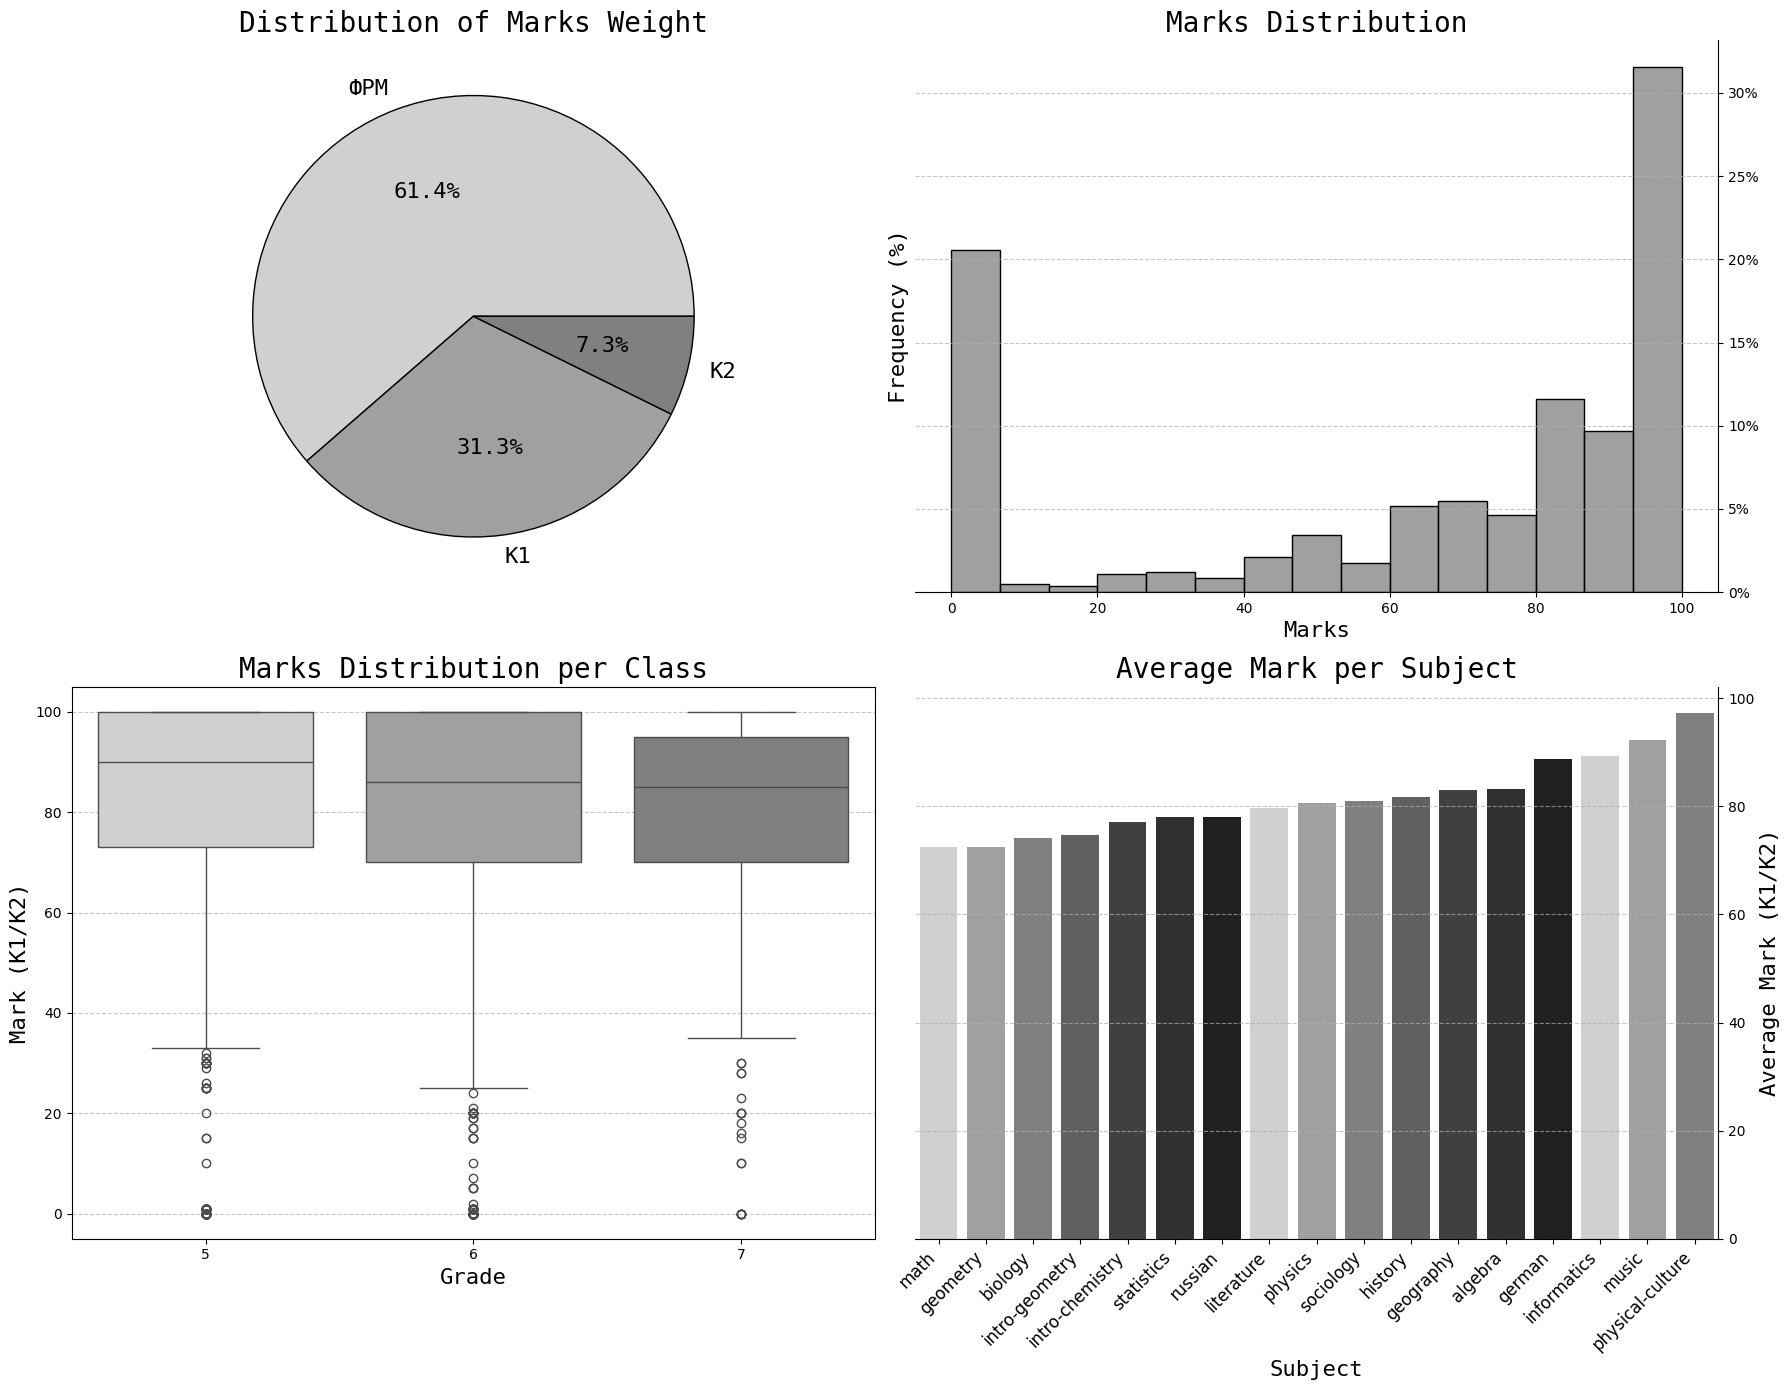

In [15]:
plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)

marks_weight_counts = main_df["marks_weight"].value_counts()
sns.set_palette(custom_dark_bw_palette)

# Grouping values less than 1% into a single "Other" category
threshold = 0.01 * marks_weight_counts.sum()
marks_weight_grouped = marks_weight_counts.copy()
marks_weight_grouped["Other"] = marks_weight_grouped[
    marks_weight_grouped < threshold
].sum()
marks_weight_grouped = marks_weight_grouped[marks_weight_grouped >= threshold]

# Plotting the updated pie chart on the 'marks weight' column
plt.pie(
    marks_weight_grouped,
    labels=marks_weight_grouped.index,
    autopct="%1.1f%%",
    colors=custom_dark_bw_palette,
    textprops={"color": "black", "fontfamily": "monospace", "fontsize": 16},
    wedgeprops={"edgecolor": "black", "linewidth": 1},
)
plt.title(
    "Distribution of Marks Weight",
    color="black",
    fontfamily="monospace",
    fontsize=20,
)

# Histogram of marks
plt.subplot(2, 2, 2)

sns.histplot(main_df["mark"], bins=15, kde=False, color="#808080", stat="percent")
plt.title("Marks Distribution", fontfamily="monospace", color="black", fontsize=20)
plt.xlabel("Marks", fontsize=16, fontfamily="monospace")
plt.ylabel("Frequency (%)", fontsize=16, fontfamily="monospace")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))
plt.gca().yaxis.tick_right()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

# Necessary to make the plot...
class_counts = main_df["grade"].value_counts()
subject_avg_marks = (
    main_df[main_df["marks_weight"].isin({"К1", "К2"})]
    .groupby("subject")["mark"]
    .mean()
    .sort_values()
)

# Third Plot: Box plot for marks per class
plt.subplot(2, 2, 3)

filtered_df = main_df[main_df["marks_weight"].isin({"К1", "К2"})]
sns.boxplot(x="grade", y="mark", data=filtered_df, palette=custom_dark_bw_palette)

plt.title(
    "Marks Distribution per Class",
    fontfamily="monospace",
    color="black",
    fontsize=20,
)
plt.xlabel("Grade", fontfamily="monospace", fontsize=16)
plt.ylabel("Mark (К1/К2)", fontfamily="monospace", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Fourth Plot: Average mark per subject
plt.subplot(2, 2, 4)
sns.barplot(
    x=subject_avg_marks.index,
    y=subject_avg_marks.values,
    palette=custom_dark_bw_palette,
)
plt.title(
    "Average Mark per Subject",
    fontfamily="monospace",
    color="black",
    fontsize=20,
)
plt.xlabel("Subject", fontfamily="monospace", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.ylabel("Average Mark (К1/К2)", fontfamily="monospace", fontsize=16)

plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("figures/main.png", dpi=300)

In [16]:
# Get the student IDs with the largest number of marks in math for the first year
main_df[
    (main_df["subject"] == "math")
    & (main_df["marks_weight"].isin({"К1", "К2"}))
].groupby("student_id")["mark"].agg(
    ["mean", "count"],
).sort_values(by="count", ascending=False)

,mean,count
student_id,,
Student_1047,83.614035,57
Student_8499,87.038462,52
Student_8787,89.784314,51
Student_1093,68.400000,50
Student_8008,88.820000,50
Student_6300,68.229167,48
Student_2940,64.340426,47
Student_9940,59.787234,47
Student_3275,71.760870,46


In [17]:
def get_student_series_of_math_grades(
    df: pd.DataFrame,
    student_id: str,
    assessment: set[str],
) -> pd.DataFrame:
    """Get student series of math grades.

    Args:
        df (pd.DataFrame): DataFrame with all data
        student_id (str): Student ID
        assessment (set[str], optional): Assessment..

    Returns:
        pd.DataFrame: Student series of math grades

    """
    target_data = df[
        (df["student_id"] == student_id)
        & (df["marks_weight"].isin(assessment))
        & (df["subject"] == "math")
        & (df["mark"] != 0)
    ]

    # Удалим 0, так как они не считаются в нашей системе
    return target_data[target_data["mark"] != 0]


get_student_series_of_math_grades(
    main_df,
    "Student_8787",
    assessment={"К1", "К2"},
).head(10)

,student_id,mark,grade,subject,trimester,marks_weight,mark_date
3376,Student_8787,100,6,math,3,К1,2024-03-04
3392,Student_8787,91,6,math,3,К2,2024-03-06
3476,Student_8787,95,6,math,3,К1,2024-03-18
3492,Student_8787,90,6,math,3,К2,2024-03-20
3571,Student_8787,100,6,math,3,К1,2024-04-03
3601,Student_8787,100,6,math,3,К1,2024-04-18
3617,Student_8787,85,6,math,3,К1,2024-04-18
3633,Student_8787,100,6,math,3,К1,2024-04-22
3649,Student_8787,100,6,math,3,К1,2024-04-22
3695,Student_8787,100,6,math,3,К1,2024-04-27


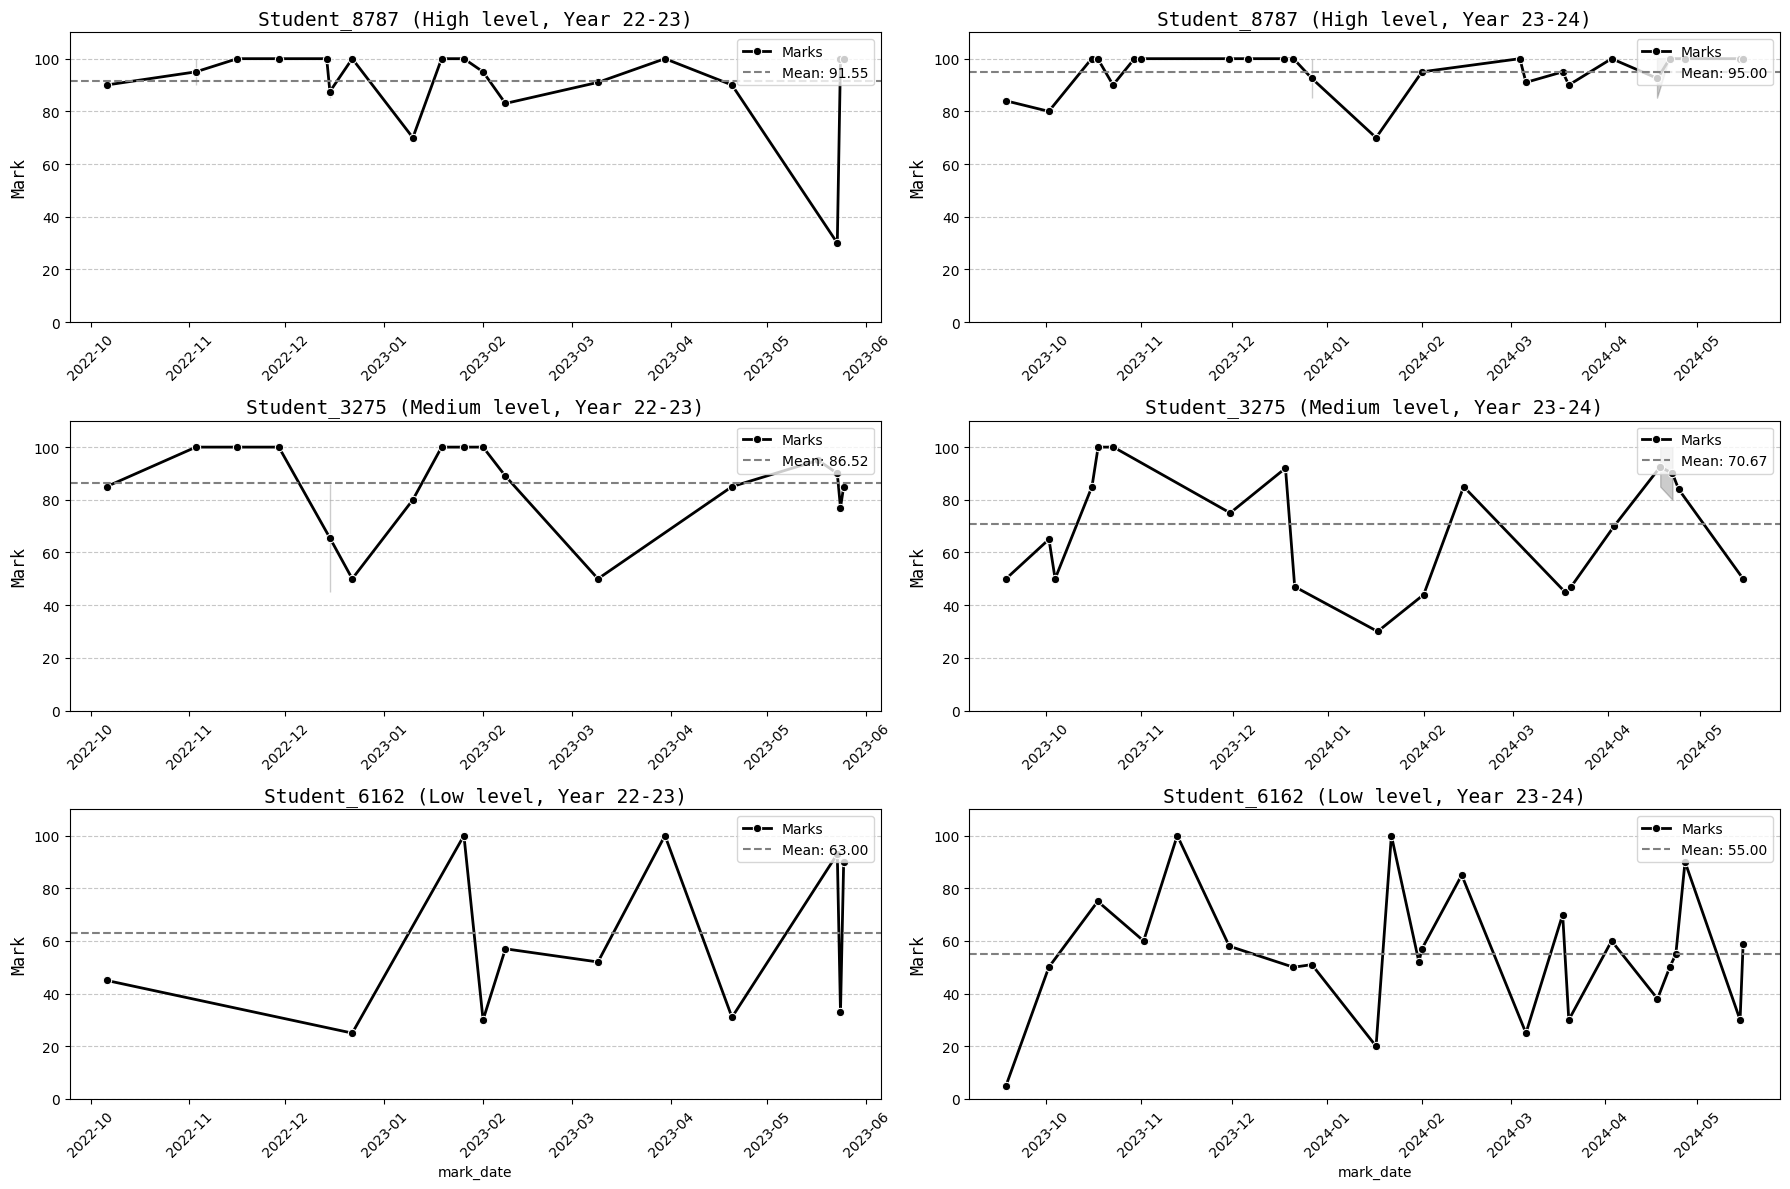

In [18]:
target_students = [
    ("Student_8787", "High"),
    ("Student_3275", "Medium"),
    ("Student_6162", "Low"),
]

year_22_23 = (pd.Timestamp("2022-09-01"), pd.Timestamp("2023-05-31"))
year_23_24 = (pd.Timestamp("2023-09-01"), pd.Timestamp("2024-05-31"))

plt.figure(figsize=(18, 12))

for i, (student_id, grade_level) in enumerate(target_students, 1):
    target_df = get_student_series_of_math_grades(
        main_df,
        student_id,
        assessment={"К1", "К2"},
    )

    year_df_22_23 = target_df[
        (target_df["mark_date"] >= year_22_23[0])
        & (target_df["mark_date"] <= year_22_23[1])
    ]
    year_df_23_24 = target_df[
        (target_df["mark_date"] >= year_23_24[0])
        & (target_df["mark_date"] <= year_23_24[1])
    ]

    plt.subplot(len(target_students), 2, 2 * i - 1)
    sns.lineplot(
        data=year_df_22_23,
        x="mark_date",
        y="mark",
        marker="o",
        linewidth=2,
        label="Marks",
        color="black",
    )

    if not year_df_22_23.empty:
        avg_mark = year_df_22_23["mark"].mean()
        plt.axhline(
            avg_mark,
            color="gray",
            linestyle="--",
            label=f"Mean: {avg_mark:.2f}",
        )

    plt.ylim(0, 110)
    plt.title(
        f"{student_id} ({grade_level} level, Year 22-23)",
        fontsize=14,
        fontfamily="monospace",
    )

    plt.ylabel("Mark", fontsize=12, fontfamily="monospace")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=10)

    if i != len(target_students):
        plt.xlabel(None)

    plt.subplot(len(target_students), 2, 2 * i)
    sns.lineplot(
        data=year_df_23_24,
        x="mark_date",
        y="mark",
        marker="o",
        linewidth=2,
        label="Marks",
        color="black",
    )

    if not year_df_23_24.empty:
        avg_mark = year_df_23_24["mark"].mean()
        plt.axhline(
            avg_mark,
            color="gray",
            linestyle="--",
            label=f"Mean: {avg_mark:.2f}",
        )

    plt.ylim(0, 110)
    plt.title(
        f"{student_id} ({grade_level} level, Year 23-24)",
        fontsize=14,
        fontfamily="monospace",
    )

    plt.ylabel("Mark", fontsize=12, fontfamily="monospace")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
    plt.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=10)

    if i != len(target_students):
        plt.xlabel(None)

plt.tight_layout()
plt.savefig("figures/mark_time_series.png")

Let's create the same chart for the same students, but based on formative assessments.

![](https://i.ibb.co/sVjj3h2/mark-time-series-frm.png)

We can immediately notice that regardless of the student's level, they might not complete assignments and receive a score of 1 for them, as these do not affect the final grade (in the case of mathematics). 

Therefore, if formative assessments do not influence the final grade, it becomes entirely meaningless to try predicting future formative scores due to the high variance in their values.

So in further analysis, we will generally exclude formative grades and grades equal to 0, as they do not affect the final grade.

_Now let's take a look at the variance of summative assessment scores in mathematics among students of different levels._

In [19]:
for student_id, level in target_students:
    target_df = get_student_series_of_math_grades(
        main_df,
        student_id,
        assessment={"К1", "К2"},
    )

    year_df_22_23 = target_df[
        (target_df["mark_date"] >= year_22_23[0])
        & (target_df["mark_date"] <= year_22_23[1])
    ]
    year_df_23_24 = target_df[
        (target_df["mark_date"] >= year_23_24[0])
        & (target_df["mark_date"] <= year_23_24[1])
    ]

    print(
        f"2022-2023 grade dispersion for student ({student_id}) with {level} level ({target_df['mark'].mean().round(2)}):",  # noqa: E501
        year_df_22_23["mark"].var().round(2),
    )
    print(
        f"2023-2024 grade dispersion for student ({student_id}) with {level} level ({target_df['mark'].mean().round(2)}):",  # noqa: E501
        year_df_23_24["mark"].var().round(2),
    )
    print("----------")

2022-2023 grade dispersion for student (Student_8787) with High level (93.45): 249.88
2023-2024 grade dispersion for student (Student_8787) with High level (93.45): 63.92
----------
2022-2023 grade dispersion for student (Student_3275) with Medium level (78.6): 312.86
2023-2024 grade dispersion for student (Student_3275) with Medium level (78.6): 512.73
----------
2022-2023 grade dispersion for student (Student_6162) with Low level (57.67): 970.36
2023-2024 grade dispersion for student (Student_6162) with Low level (57.67): 572.52
----------


In [20]:
target_subjects = [
    "math",
    "russian",
    "biology",
]

students = []
mean_marks = []

for subject in target_subjects:
    # Get the student IDs with the largest number of marks in subject for the first year
    target_df = (
        main_df[
            (main_df["subject"] == subject)
            & (main_df["marks_weight"].isin({"К1", "К2"}))
        ]
        .groupby("student_id")["mark"]
        .agg(
            ["mean", "count"],
        )
        .sort_values(by="count", ascending=False)[:16]
        .sort_values(by="mean", ascending=False)
    )
    students.append(target_df["mean"].index.to_list())
    mean_marks.append(target_df["mean"].to_list())

len(students[0]), len(students[1]), len(students[2])

(16, 16, 16)

In [21]:
dispersions: list[list[float]] = []
for i, subject in enumerate(target_subjects):
    group_tp_append: list[float] = []
    for student in students[i]:
        student_marks = main_df[
            (main_df["student_id"] == student)
            & (main_df["subject"] == subject)
            & (main_df["marks_weight"].isin({"К1", "К2"}))
            & (main_df["mark"] != 0)
        ]
        var = student_marks["mark"].var()
        group_tp_append.append(var)
    dispersions.append(group_tp_append)
len(dispersions), len(dispersions[0])

(3, 16)

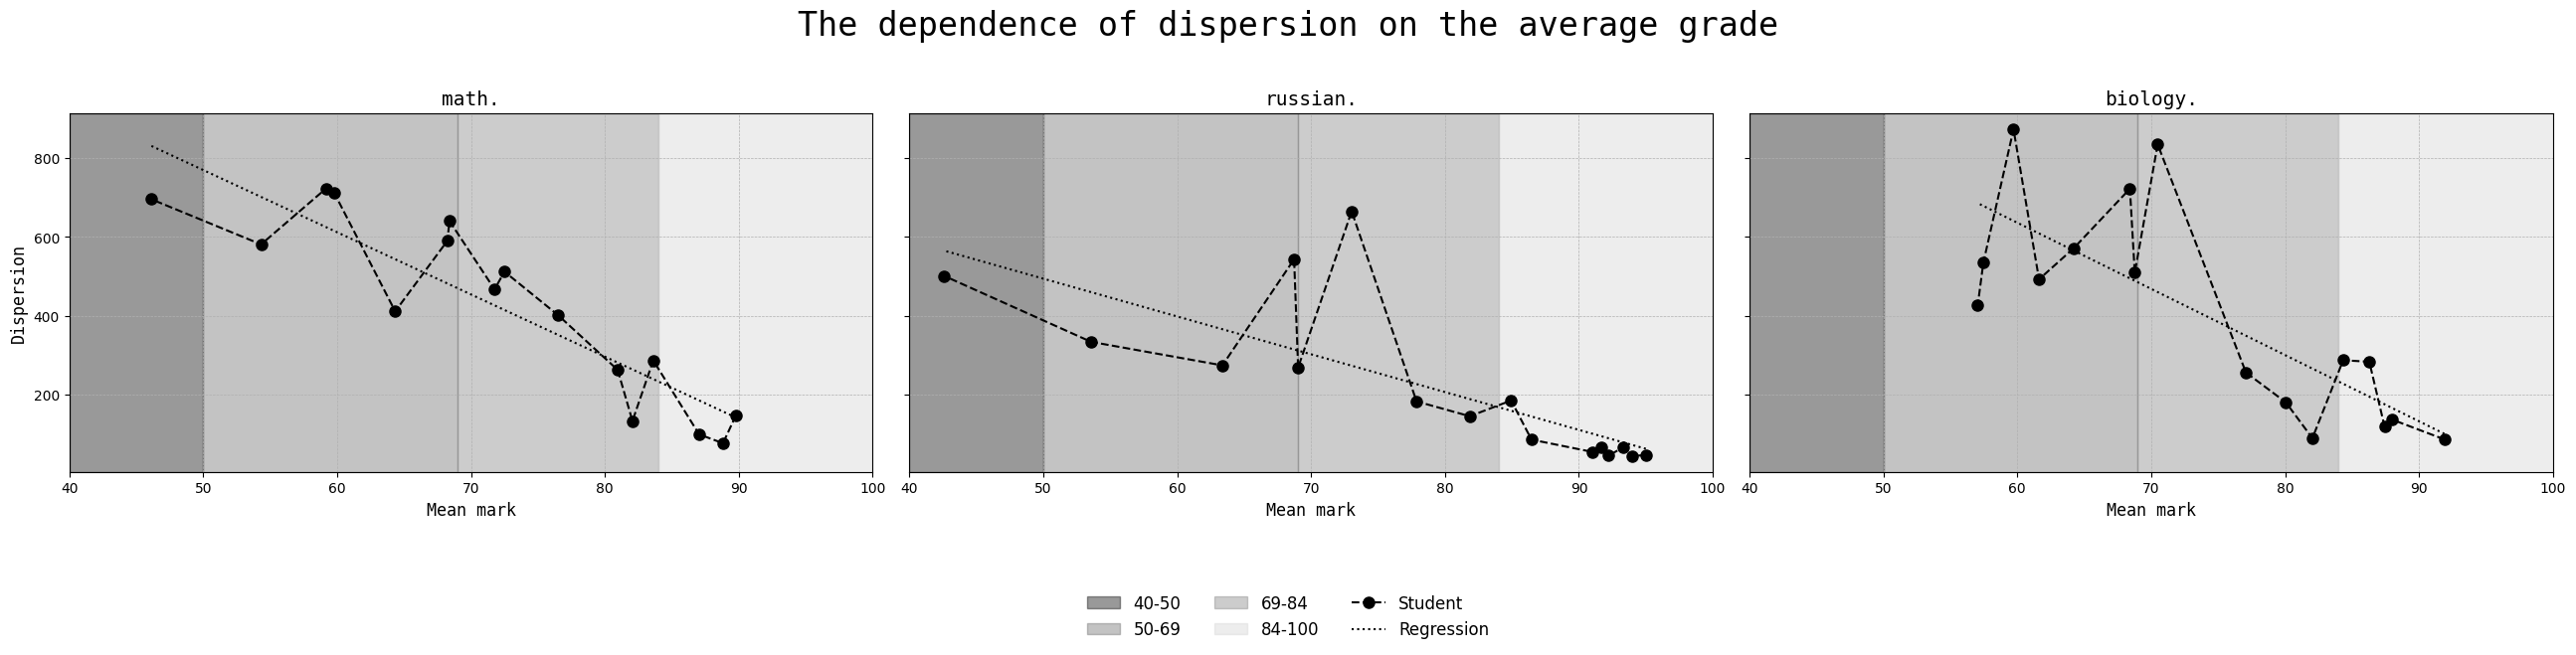

In [22]:
import numpy as np

fig, axes = plt.subplots(1, len(target_subjects), figsize=(26, 6), sharey=True)

ranges = [(40, 50), (50, 69), (69, 84), (84, 100)]
range_colors = ["black", "dimgray", "gray", "lightgray"]


for i, (subject, ax) in enumerate(zip(target_subjects, axes)):
    for r, color in zip(ranges, range_colors):
        ax.axvspan(
            r[0],
            r[1],
            color=color,
            alpha=0.4,
            label=f"{r[0]}-{r[1]}" if i == 0 else "",
        )

    ax.plot(
        mean_marks[i],
        dispersions[i],
        linestyle="--",
        marker="o",
        color="black",
        markersize=8,
        label="Student",
    )

    coeffs = np.polyfit(
        mean_marks[i],
        dispersions[i],
        1,
    )
    regression_line = np.polyval(coeffs, mean_marks[i])

    ax.plot(
        mean_marks[i],
        regression_line,
        color="black",
        linestyle=":",
        label="Regression",
    )

    ax.set_xlim(40, 100)
    ax.set_title(
        f"{subject}.",
        fontsize=14,
        family="monospace",
    )
    ax.grid(False)
    ax.set_xlabel("Mean mark", fontsize=12, family="monospace")
    if i == 0:
        ax.set_ylabel("Dispersion", fontsize=12, family="monospace")
    ax.grid(True, linestyle="--", linewidth=0.5)

fig.suptitle(
    "The dependence of dispersion on the average grade",
    fontsize=24,
    family="monospace",
)

fig.legend(
    loc="lower center",
    fontsize=12,
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1),
    labels=["40-50", "50-69", "69-84", "84-100", "Student", "Regression"],
)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.savefig(
    "figures/dependence-of-dispersion-on-the-average-grade.png",
    bbox_inches="tight",
)

The low variance in grades of successful students can be explained by the lower difficulty level of school assignments for them => they complete all schoolwork with scores close to or equal to the maximum.

In [23]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficients and p-values
results = []
for subject, marks, disp in zip(target_subjects, mean_marks, dispersions):
    corr, p_value = pearsonr(marks, disp)
    results.append({
        "Subject": subject,
        "Correlation Coefficient": corr,
        "P-Value": "{f:.2}".format(f=p_value),
    })

correlation_df = pd.DataFrame(results)
correlation_df

,Subject,Correlation Coefficient,P-Value
0,math,-0.896996,2.5e-06
1,russian,-0.759978,0.00063
2,biology,-0.769346,0.00049


Now let's check the students' grades for stationarity and seasonality.

If the hypotheses of stationarity and absence of seasonality are confirmed, high variance will indicate the lack of determinism in subsequent grades. This means that primitive methods for predicting future grades will be less applicable in cases of high variance.

In [24]:
filtered_main_df = main_df[
    (main_df["marks_weight"].isin(["К1", "К2"])) & (main_df["mark"] != 0)
]

top_students_per_subject = (
    filtered_main_df.groupby("subject")
    .apply(lambda group: group.groupby("student_id").size().nlargest(3))
    .reset_index(name="marks_count")
)

top_students_per_subject = top_students_per_subject.sort_values(
    by="marks_count",
    ascending=False,
)

top_students_per_subject = top_students_per_subject.drop_duplicates(
    subset="student_id",
    keep="first",
)

top_students_per_subject.head(10)

/tmp/ipykernel_107290/1002983243.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.groupby("student_id").size().nlargest(3))


,subject,student_id,marks_count
30,math,Student_1047,55
31,math,Student_8499,49
32,math,Student_8787,49
42,russian,Student_1093,34
43,russian,Student_7905,34
44,russian,Student_8008,34
27,literature,Student_6300,32
17,history,Student_3435,26
16,history,Student_2940,26
26,intro-geometry,Student_3275,20


In [25]:
import statsmodels.api as sm

top_students = top_students_per_subject.head(10)

trend_results = []

for _, row in top_students.iterrows():
    student_id = row["student_id"]
    subject = row["subject"]

    student_data = main_df[
        (main_df["student_id"] == student_id)
        & (main_df["subject"] == subject)
        & (main_df["marks_weight"].isin(["К1", "К2"]))
        & (main_df["mark"] != 0)
    ]
    student_data = student_data.reset_index(drop=True, inplace=False)
    student_data = student_data.sort_values("mark_date")

    student_data["time"] = range(len(student_data))

    X = sm.add_constant(student_data["time"])
    y = student_data["mark"]
    model = sm.OLS(y, X).fit()

    p_value = model.pvalues["time"]
    trend_absent = p_value > 0.05

    trend_results.append({
        "student_id": student_id,
        "subject": subject,
        "p_value": "{:.2}".format(p_value),
        "trend_absent": trend_absent,
    })

# Формируем DataFrame
trend_results_df = pd.DataFrame(trend_results)
trend_results_df

,student_id,subject,p_value,trend_absent
0,Student_1047,math,0.27,True
1,Student_8499,math,0.063,True
2,Student_8787,math,0.46,True
3,Student_1093,russian,0.98,True
4,Student_7905,russian,0.93,True
5,Student_8008,russian,0.0017,False
6,Student_6300,literature,0.95,True
7,Student_3435,history,0.77,True
8,Student_2940,history,0.0001,False
9,Student_3275,intro-geometry,0.53,True


In most time series, we cannot confirm the presence of a trend. In such cases, this may indicate a high prediction error for models that base their forecasts on identifying a trend. Here, the error will depend on the variance.

In some time series, the presence of a trend is confirmed, which may suggest that high grade variance in these cases does not necessarily lead to high prediction errors for grade prediction models (the variance may be caused by a trend).

This highlights the applicability of basic time series prediction algorithms for forecasting grades.

In [26]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle



def check_seasonality(student_data: pd.DataFrame) -> dict:
    """Check seasonality of student's marks using Lomb-Scargle periodogram.

    Args:
        student_data (pd.DataFrame): DataFrame with student's marks

    Returns:
        dict: Dictionary with results

    """
    student_data = student_data.sort_values("mark_date")
    student_data = student_data.dropna(subset=["mark"])
    time = (
        pd.to_datetime(student_data.index).astype(np.int64) / 1e9
    )
    marks = student_data["mark"].to_numpy()

    if len(np.unique(time)) < 2:
        return {"result": "Not enough unique time points"}

    min_period = 2
    max_period = 60
    frequencies = np.linspace(
        1 / (max_period * 86400), 1 / (min_period * 86400), 1000,
    )

    ls = LombScargle(time, marks)
    power = ls.power(frequencies)
    periods = 1 / frequencies / 86400

    false_alarm_probs = ls.false_alarm_probability(power)

    valid_periods = periods[(periods > 14) & (false_alarm_probs < 0.05) & (power > 0.3)]

    if len(valid_periods) > 0:
        best_period = valid_periods[0]
        return {
            "result": "Seasonality is confirmed",
            "best_period": best_period,
            "false_alarm_probability": false_alarm_probs[np.argmax(power)],
        }
    else:
        return {
            "result": "No significant periods > 14 days",
            "best_period": None,
            "false_alarm_probability": None,
        }


final_results = []

for _, row in top_students.iterrows():
    student_id = row["student_id"]
    subject = row["subject"]

    student_data = main_df[
        (main_df["student_id"] == student_id)
        & (main_df["subject"] == subject)
        & (main_df["marks_weight"].isin(["К1", "К2"]))
        & (main_df["mark"] != 0)
    ]
    student_data = student_data.sort_values("mark_date")
    student_data.set_index("mark_date", inplace=True)

    if len(student_data) >= 20:
        seasonality_result = check_seasonality(student_data)

        if seasonality_result["result"] == "Not enough unique time points":
            result = "Not enough data for seasonality analysis"
        elif seasonality_result["result"] == "No significant periods > 14 days":
            result = "No significant seasonality found"
        else:
            result = seasonality_result["result"]

        final_results.append({
            "student_id": student_id,
            "subject": subject,
            "result": result,
            "best_period": seasonality_result["best_period"],
            "false_alarm_probability": seasonality_result["false_alarm_probability"],
        })

final_seasonality_df = pd.DataFrame(final_results)
final_seasonality_df

/home/ultrageopro/.cache/pypoetry/virtualenvs/analysis-of-school-grades-school-essay-Vb2x0zaM-py3.12/lib/python3.12/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


,student_id,subject,result,best_period,false_alarm_probability
0,Student_1047,math,No significant seasonality found,NaN,NaN
1,Student_8499,math,Seasonality is confirmed,22.851697,0.000822
2,Student_8787,math,No significant seasonality found,NaN,NaN
3,Student_1093,russian,No significant seasonality found,NaN,NaN
4,Student_7905,russian,No significant seasonality found,NaN,NaN
5,Student_8008,russian,No significant seasonality found,NaN,NaN
6,Student_6300,literature,No significant seasonality found,NaN,NaN
7,Student_3435,history,No significant seasonality found,NaN,NaN
8,Student_2940,history,No significant seasonality found,NaN,NaN
9,Student_3275,intro-geometry,No significant seasonality found,NaN,NaN


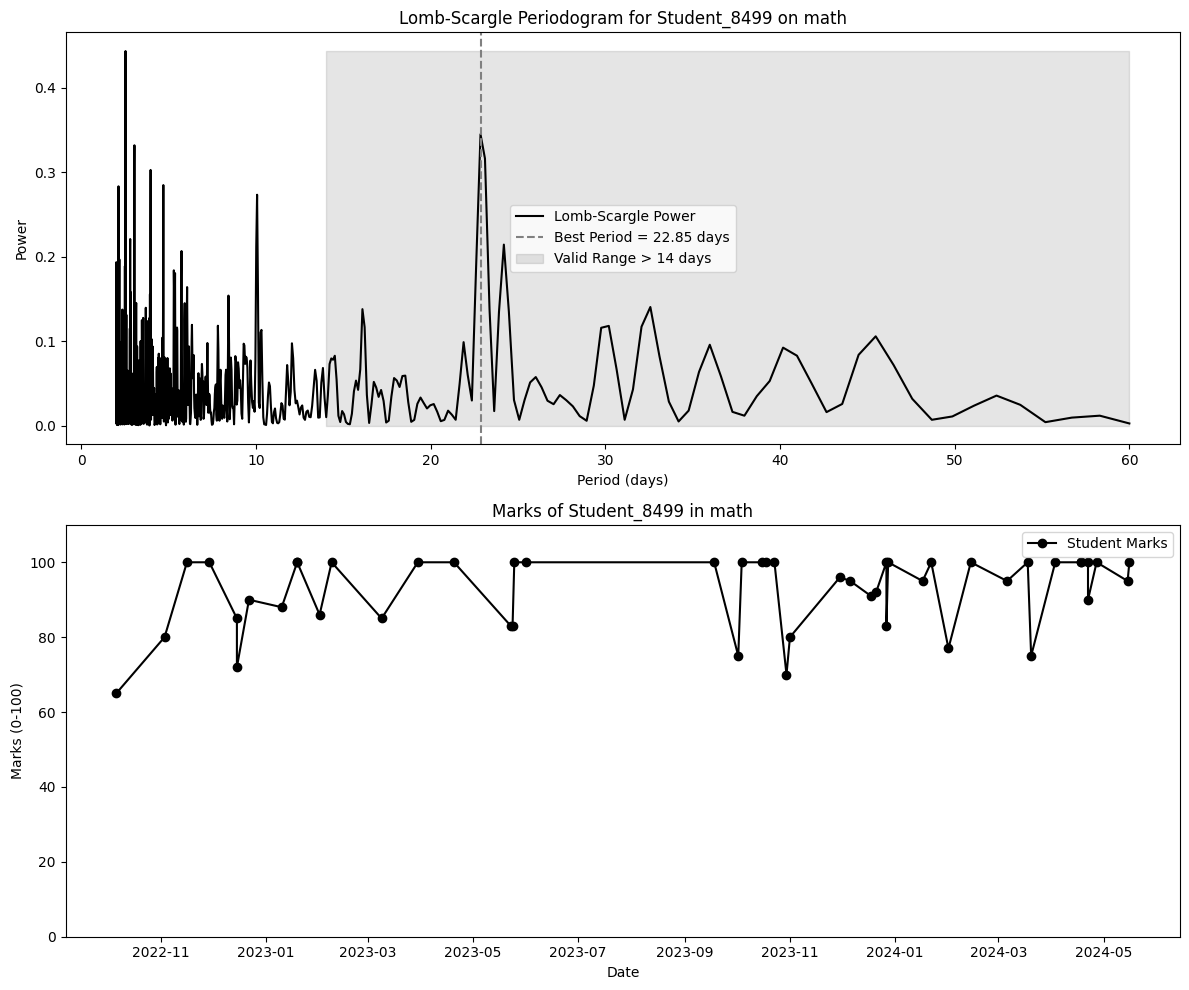

Best period: 22.85 days
False alarm probability: 0.0280


In [27]:
# Filtering data for a specific student and subject
student_id = "Student_8499"
subject = "math"

student_data = main_df[
    (main_df["student_id"] == student_id)
    & (main_df["subject"] == subject)
    & (main_df["marks_weight"].isin(["К1", "К2"]))
    & (main_df["mark"] != 0)
]


# Sorting by date and setting the date as the index
student_data = student_data.sort_values("mark_date")
student_data.set_index("mark_date", inplace=True)

# Dropping missing marks and converting dates to numerical format
student_data = student_data.dropna(subset=["mark"])
time = pd.to_datetime(student_data.index).astype(np.int64) / 1e9  # Convert to seconds
marks = student_data["mark"].to_numpy()

# Setting the frequency range for the search
min_period = 2  # Minimum period in days
max_period = 60  # Maximum period in days
frequencies = np.linspace(
    1 / (max_period * 86400),
    1 / (min_period * 86400),
    1000,
)

# Calculating the Lomb-Scargle periodogram
ls = LombScargle(time, marks)
power = ls.power(frequencies)
periods = 1 / frequencies / 86400  # Convert frequencies to periods in days

# Filtering periods greater than 14 days
valid_periods_mask = periods > 14
valid_periods = periods[valid_periods_mask]
valid_power = power[valid_periods_mask]

# Finding the best period in the valid range
best_frequency_idx = np.argmax(valid_power)
best_period = valid_periods[best_frequency_idx]
false_alarm_prob = ls.false_alarm_probability(valid_power[best_frequency_idx])

# Plotting the periodogram with the valid range highlighted in black and white
fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))

# First subplot: Lomb-Scargle periodogram
ax1[0].plot(periods, power, color="black", label="Lomb-Scargle Power", linestyle="-")
ax1[0].set_xlabel("Period (days)")
ax1[0].set_ylabel("Power")
ax1[0].set_title(f"Lomb-Scargle Periodogram for {student_id} on {subject}")
ax1[0].axvline(
    best_period,
    color="gray",
    linestyle="--",
    label=f"Best Period = {best_period:.2f} days",
)

# Highlighting the valid range (>14 days)
ax1[0].fill_betweenx(
    y=[0, max(power)],
    x1=14,
    x2=max_period,
    color="black",
    alpha=0.1,
    label="Valid Range > 14 days",
)

ax1[0].legend()

# Second subplot: Student marks over time
ax1[1].plot(
    pd.to_datetime(student_data.index),
    marks,
    label="Student Marks",
    color="black",
    marker="o",
    linestyle="-",
)
ax1[1].set_ylim(0, 110)  # Set Y-axis limits for marks
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("Marks (0-100)")
ax1[1].set_title(f"Marks of {student_id} in {subject}")
ax1[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("figures/period.png")
plt.show()


print(f"Best period: {best_period:.2f} days")
print(f"False alarm probability: {false_alarm_prob:.4f}")

Due to the high likelihood of errors in conclusions based on sampled data or the minimal impact of the seasonal component, we cannot consistently confirm the presence of seasonality in the data (across all possible periods).

Grades occasionally exhibit periodicity, though it may be challenging to detect due to the limited number of grades. Nevertheless, in cases where periodicity exists and significantly influences subsequent grades, advanced models accounting for this periodicity can be expected to yield lower error rates. This conclusion assumes that the observed variability in grades is not predominantly driven by a positive or negative trend, as previously confirmed.

## Pre-analysis Results

- There is no point in considering the prediction of formative grades or grades equal to 0.  
- The greatest potential for accurate grade predictions is observed for students who excel academically, for those whose grades are improving or declining (indicating a trend), and for those whose grades exhibit periodicity, such as patterns caused by monthly tests. In cases of periodicity, leveraging these recurring patterns can significantly enhance the accuracy of predictive models. 
- If there is no periodicity or trend in the data, making predictions becomes almost meaningless. For instance, if a student has low grades, statistical tests for periodicity and trend can be conducted before fitting a model. If neither is present, using further models for predictions will also be pointless. 
- Grade variance is directly dependent on the student’s academic performance.

1. Linear Regression   
2. Autoregressive Model (AR)  
3. ARIMA (AutoRegressive Integrated Moving Average)  
4. SARIMA (Seasonal ARIMA)  
5. Prophet by Facebook  

In [44]:
# ok lets get dataset of students/subjects to analyse

dataset = (
    main_df[
        (main_df["marks_weight"].isin({"К1", "К2"})) & 
        (main_df["subject"].isin({"biology", "math", "russian"}))
    ]
    .groupby(["student_id", "subject"])["mark"]
    .agg(["count"])
    .sort_values(by="count", ascending=False)
).reset_index()

threshold = 20
dataset = dataset[dataset["count"] >= threshold]
dataset.shape, dataset.columns

((45, 3), Index(['student_id', 'subject', 'count'], dtype='object'))

In [ ]:
def mse(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean squared error.

    Args:
        y_real (np.ndarray): Real values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: Mean squared error.

    """
    return np.mean((y_real - y_pred) ** 2)


def mae(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute error.

    Args:
        y_real (np.ndarray): Real values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: Mean absolute error.

    """
    return np.mean(np.abs(y_real - y_pred))


def rmse(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Root mean squared error.

    Args:
        y_real (np.ndarray): Real values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: Root mean squared error.

    """
    return np.sqrt(np.mean((y_real - y_pred) ** 2))


def mape(y_real: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Absolute Percentage Error.

    Args:
        y_real (np.ndarray): Real values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: Mean Absolute Percentage Error.

    """
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100


y_real = np.array([0.2, 1, 2, 3])
y_pred = np.array([0.1, 1.1, 1, 2.5])

mse(y_real, y_pred), mae(y_real, y_pred), rmse(y_real, y_pred), mape(y_real, y_pred)

(np.float64(0.3175),
 np.float64(0.42500000000000004),
 np.float64(0.5634713834792322),
 np.float64(31.66666666666667))